# Loading packages

In [1]:
!pip install medmnist
!pip install evaluate
!pip install wandb
!pip install fastai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.7 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=

In [2]:
from transformers import ViTImageProcessor, ViTForImageClassification, ViTConfig, ViTModel
from PIL import Image
import requests
from medmnist import OCTMNIST, PathMNIST, DermaMNIST, RetinaMNIST, BloodMNIST
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from medmnist import INFO, Evaluator
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
from evaluate import load
from transformers import TrainingArguments, Trainer
import os
from fastai.vision.augment import Resize, ResizeMethod
from data_augmentation import ConcatDataset, UpdateLabelsMNSIT, DatasetAugmentation

# Loading Train Data

In [3]:
path_dataset = PathMNIST(split="train", download=True)
derma_dataset = DermaMNIST(split="train", download=True)
blood_dataset = BloodMNIST(split="train", download=True)
retina_dataset = RetinaMNIST(split="train", download=True)

100%|██████████| 206M/206M [00:17<00:00, 12.1MB/s]
100%|██████████| 19.7M/19.7M [00:02<00:00, 7.70MB/s]
100%|██████████| 35.5M/35.5M [00:02<00:00, 12.4MB/s]
100%|██████████| 3.29M/3.29M [00:01<00:00, 2.93MB/s]


# Loading Validation Data

In [4]:
val_path_dataset = PathMNIST(split="val", download=True)
val_derma_dataset = DermaMNIST(split="val", download=True)
val_blood_dataset = BloodMNIST(split="val", download=True)
val_retina_dataset = RetinaMNIST(split="val", download=True)

# Loading Test Data

In [5]:
test_path_dataset = PathMNIST(split="test", download=True)
test_derma_dataset = DermaMNIST(split="test", download=True)
test_blood_dataset = BloodMNIST(split="test", download=True)
test_retina_dataset = RetinaMNIST(split="test", download=True)

# Extracting Labels

In [6]:
pathmnist_info = INFO["pathmnist"]
dermamnist_info = INFO["dermamnist"]
bloodmnist_info = INFO["bloodmnist"]
retinamnist_info = INFO["retinamnist"]

path_labels = pathmnist_info["label"].values()
derma_labels = dermamnist_info["label"].values()
blood_labels = bloodmnist_info["label"].values()
retina_labels = retinamnist_info["label"].values()

# Exploring data

In [ ]:
path_dataset[0]

100%|██████████| 206M/206M [00:17<00:00, 12.0MB/s]


(<PIL.Image.Image image mode=RGB size=28x28>, array([0]))

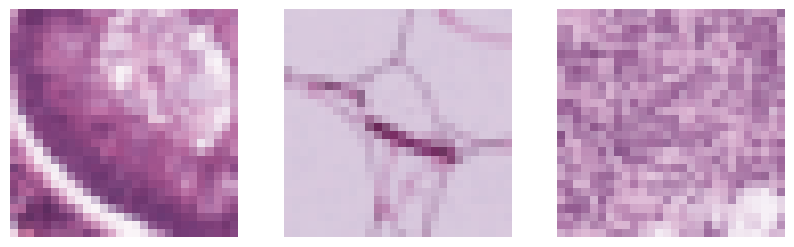

In [ ]:
rows, cols = 1, 3
figure = plt.figure(figsize=(10, 10))
for i in range(1, cols * rows + 1):

    sample_idx = torch.randint(len(path_dataset), size=(1,)).item()
    img, label = path_dataset[sample_idx]

    img_tensor = transforms.ToTensor()(img)
    img_tensor = img_tensor.permute(1, 2, 0)

    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img_tensor.squeeze())

plt.show()

In [ ]:
pathmnist_info

{'python_class': 'PathMNIST',
 'description': 'The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.',
 'url': 'https://zenodo.org/records/10519652/files/pathmnist.npz?download=1',
 'MD5': 'a8b06965200029087d5bd730944a56c1',
 'url_64': 'https://zenodo.org/records/10519652/files/pathmnist_64.npz?download=1',
 'MD5_64': '55aa9c1e0525abe5a6b9d8343a507616',
 'url_128': 'https://zenodo.org/records/10519652/files/pathmnist_128.npz?download=1',
 'MD5

In [ ]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

image = path_dataset[0][0]

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()

print("Predicted class:", model.config.id2label[predicted_class_idx])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Predicted class: nematode, nematode worm, roundworm


# Data Preparation

In [ ]:
labels = pathmnist_info["label"].values()
labels

dict_values(['adipose', 'background', 'debris', 'lymphocytes', 'mucus', 'smooth muscle', 'normal colon mucosa', 'cancer-associated stroma', 'colorectal adenocarcinoma epithelium'])

In [ ]:
labels = pathmnist_info["label"].values()
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes = True
    )

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([9]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([9, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# This is for implementing a ViT from scratch (requires specifying num of layers, etc.)
#configuration = ViTConfig(image_size=28, num_labels=len(INFO["pathmnist"]['label']))
#model = ViTForImageClassification(configuration)
#configuration = model.config
#configuration

ViTConfig {
  "_attn_implementation_autoset": true,
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "image_size": 28,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": true,
  "transformers_version": "4.50.3"
}

In [ ]:
# Important because we need a dict for fine-tuning
class CustomPathMNIST(PathMNIST):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    #self.resize= Resize(size=224, method=ResizeMethod.Squish)


  def __getitem__(self, idx):
    image, label = super().__getitem__(idx)
    #resized_image = self.resize(image)
    item = {'pixel_values' : image, 'labels' : label}
    return item


currently testing for pathmnist images since they already have images of 3 dimensions

In [ ]:
BATCH_SIZE = 64

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = CustomPathMNIST(split="train", transform=data_transform, size=28, download=True)
test_dataset = CustomPathMNIST(split="test", transform=data_transform, size=28, download=True)
val_dataset = CustomPathMNIST(split="val", transform=data_transform, size=28, download=True)


train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64, 1])
Label: tensor([6])


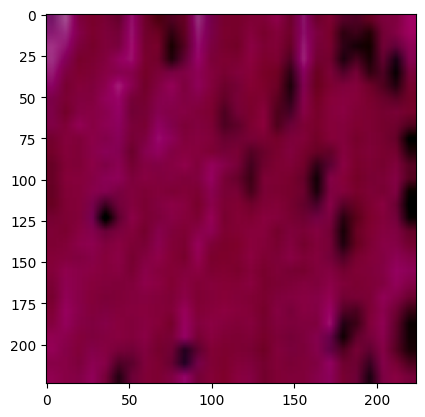

In [ ]:
train_features = next(iter(train_dataloader))['pixel_values']
train_labels = next(iter(train_dataloader))['labels']

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

label = train_labels[0]
print(f"Label: {label}")


img = train_features[0].squeeze().permute(1,2,0)
plt.imshow(img)
plt.show()


In [ ]:
# Potential image normalization (same setup as preprocessing steps in ViT article)
# (e.g. reshape image to 224 x 224, or also keep the images 28x28 but change ViT shape to 28x28 instead)

In [ ]:
# Configure dataloaders/datasets to be in supported format for fine-tuning (fix error in trainer)

# Fine-Tuning

In [ ]:
metric = load("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [ ]:
trainig_arguments = TrainingArguments(
    learning_rate = 5e-5,
    lr_scheduler_type="cosine",
    num_train_epochs=2,
    #fp16=True, # Try this or bf16 in case fine-tuning takes too much time
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,
    warmup_ratio = 0.2,
    save_strategy="epoch",
    #save_steps=10000,
    report_to="none"

)

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
trainer = Trainer(
    model=model,
    args=trainig_arguments,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

train_results = trainer.train()

Step,Training Loss
500,0.508800
1000,0.121100
1500,0.067100
2000,0.028900
2500,0.019900


In [ ]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =        1.9991
  total_flos               = 12985359421GF
  train_loss               =        0.1346
  train_runtime            =    0:32:27.32
  train_samples_per_second =         92.43
  train_steps_per_second   =         1.444


In [ ]:
metrics = trainer.evaluate(val_dataset)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =     1.9991
  eval_accuracy           =      0.992
  eval_loss               =     0.0253
  eval_runtime            = 0:00:42.28
  eval_samples_per_second =    236.577
  eval_steps_per_second   =     14.804


In [ ]:
model.config.id2label

{'0': 'adipose',
 '1': 'background',
 '2': 'debris',
 '3': 'lymphocytes',
 '4': 'mucus',
 '5': 'smooth muscle',
 '6': 'normal colon mucosa',
 '7': 'cancer-associated stroma',
 '8': 'colorectal adenocarcinoma epithelium'}

In [ ]:
def predict(idx):
  image = test_dataset[idx]['pixel_values'].to(model.device)

  outputs = model(image.unsqueeze(0))
  logits = outputs.logits

  predicted_class_idx = logits.argmax(-1).item()
  real_class_idx = test_dataset[idx]['labels'].item()
  print("Predicted class:", model.config.id2label[f'{predicted_class_idx}'])
  print("Real Class: ", model.config.id2label[f'{real_class_idx}'])

In [ ]:
predict(0)

Predicted class: colorectal adenocarcinoma epithelium
Real Class:  colorectal adenocarcinoma epithelium


In [ ]:
predict(200)

Predicted class: adipose
Real Class:  adipose


In [ ]:
correct_predictions = 0

for idx in range(len(test_dataset)):
  image = test_dataset[idx]['pixel_values'].to(model.device)
  outputs = model(image.unsqueeze(0))
  logits = outputs.logits

  predicted_class_idx = logits.argmax(-1).item()

  if predicted_class_idx == test_dataset[idx]['labels'].item():
    correct_predictions += 1

print(f"Fine-tuning accuracy on test dataset: {(correct_predictions / len(test_dataset))*100}%")

Fine-tuning accuracy on test dataset: 94.22005571030641%


# Fine-tuning on Concat dataset

In [7]:
labels = list(path_labels) + list(derma_labels) + list(blood_labels) + list(retina_labels)
labels

['adipose',
 'background',
 'debris',
 'lymphocytes',
 'mucus',
 'smooth muscle',
 'normal colon mucosa',
 'cancer-associated stroma',
 'colorectal adenocarcinoma epithelium',
 'actinic keratoses and intraepithelial carcinoma',
 'basal cell carcinoma',
 'benign keratosis-like lesions',
 'dermatofibroma',
 'melanoma',
 'melanocytic nevi',
 'vascular lesions',
 'basophil',
 'eosinophil',
 'erythroblast',
 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)',
 'lymphocyte',
 'monocyte',
 'neutrophil',
 'platelet',
 '0',
 '1',
 '2',
 '3',
 '4']

In [8]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes = True
    )
model.config

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "adipose",
    "1": "background",
    "10": "basal cell carcinoma",
    "11": "benign keratosis-like lesions",
    "12": "dermatofibroma",
    "13": "melanoma",
    "14": "melanocytic nevi",
    "15": "vascular lesions",
    "16": "basophil",
    "17": "eosinophil",
    "18": "erythroblast",
    "19": "immature granulocytes(myelocytes, metamyelocytes and promyelocytes)",
    "2": "debris",
    "20": "lymphocyte",
    "21": "monocyte",
    "22": "neutrophil",
    "23": "platelet",
    "24": "0",
    "25": "1",
    "26": "2",
    "27": "3",
    "28": "4",
    "3": "lymphocytes",
    "4": "mucus",
    "5": "smooth muscle",
    "6": "normal colon mucosa",
    "7": "cancer-associated stroma",
    "8": "colorectal adenocar

In [9]:
import torchvision.transforms as T

class CustomMNIST(Dataset):
  def __init__(self, dataset, *args, **kwargs):

    super(CustomMNIST, self).__init__()

    self.data_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[.5], std=[.5])
      ])

    self.dataset = dataset
    self.transform = T.ToPILImage()

  def __len__(self):
    return len(self.dataset)


  def __getitem__(self, idx):
    image, label = self.dataset[idx]

    if isinstance(image, torch.Tensor):
          image = self.transform(image)

    image = self.data_transform(image)

    item = {'pixel_values' : image, 'labels' : label}
    return item


In [10]:
train_subset = 1080
concat_dataset = ConcatDataset(path_dataset, derma_dataset, blood_dataset, retina_dataset, train_subset)
augmented_dataset = DatasetAugmentation(concat_dataset)
train_dataset = CustomMNIST(augmented_dataset)

Concatenating datasets


In [11]:
validation_subset = 120
concat_val_dataset = ConcatDataset(val_path_dataset, val_derma_dataset, val_blood_dataset, val_retina_dataset, validation_subset)
val_dataset = CustomMNIST(concat_val_dataset)

Concatenating datasets


In [12]:
test_subset = 400
concat_test_dataset = ConcatDataset(test_path_dataset, test_derma_dataset, test_blood_dataset, test_retina_dataset, test_subset)
test_dataset = CustomMNIST(concat_test_dataset)

Concatenating datasets


In [13]:
metric = load("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


In [14]:
def TopKAccuracy(test_dataset, k):
  correct_predictions = 0

  for idx in range(len(test_dataset)):
    image = test_dataset[idx]['pixel_values'].to(model.device)
    outputs = model(image.unsqueeze(0))
    logits = outputs.logits

    values, indices = torch.topk(logits, k)
    indices = indices.tolist()

    if test_dataset[idx]['labels'].item() in indices[0]:
      correct_predictions += 1

  print(f"Fine-tuning Top-{k} Accuracy on test dataset: {(correct_predictions / len(test_dataset))*100}%")

In [15]:
trainig_arguments = TrainingArguments(
    learning_rate = 5e-5,
    lr_scheduler_type="cosine",
    num_train_epochs=2,
    #fp16=True, # Try this or bf16 in case fine-tuning takes too much time
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,
    warmup_ratio = 0.2,
    save_strategy="epoch",
    #save_steps=10000,
    report_to="none"

)

In [16]:
os.environ["WANDB_DISABLED"] = "true"

In [17]:
trainer = Trainer(
    model=model,
    args=trainig_arguments,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

train_results = trainer.train()

Step,Training Loss
500,1.211500
1000,0.404500


In [18]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =          2.0
  total_flos               = 4989600268GF
  train_loss               =       0.7725
  train_runtime            =   0:39:53.65
  train_samples_per_second =       28.876
  train_steps_per_second   =        0.451


In [19]:
metrics = trainer.evaluate(val_dataset)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.7979
  eval_loss               =      0.541
  eval_runtime            = 0:00:06.00
  eval_samples_per_second =     79.923
  eval_steps_per_second   =      4.995


In [20]:
TopKAccuracy(test_dataset, 1)
TopKAccuracy(test_dataset, 5)

Fine-tuning Top-1 Accuracy on test dataset: 77.5%
Fine-tuning Top-5 Accuracy on test dataset: 99.75%
